In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the structure of the bars

In [2]:
def plot_struct(struct):
    fig, ax = plt.subplots()
    # Plotting nodes
    for i in range(len(struct)):
        ax.scatter(struct.loc[i][0], struct.loc[i][1], color='#000000', linewidths = 16)
    # Plotting bars
    for k in range(len(struct)):
        for i in range(len(struct)):
            if struct.loc[k][i+2] == 1:
                plt.plot([struct.loc[i][0], struct.loc[k][0]], [struct.loc[i][1], struct.loc[k][1]],color='b', linewidth=8)

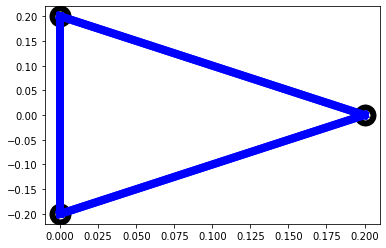

In [5]:
structure = pd.read_csv("data3.csv")
plot_struct(structure)

In [6]:
structure

,x,y,n1,n2,n3,ddl,Px,Py
0,0.0,0.2,0,1,1,3,0,0
1,0.2,0.0,1,0,1,0,0,-10000
2,0.0,-0.2,1,1,0,1,0,0


Assemblage et calcul des déplacements inconnus

In [7]:
def ddl_vect(struct):
    nbr_ddl = 1
    v_ddl = np.array([0 for i in range(len(struct)*2)])
    for i in range(len(struct)):
        if struct['ddl'][i] == 0:
            v_ddl[2*i:2*i+2] = [nbr_ddl,nbr_ddl+1] 
            nbr_ddl = nbr_ddl+2
        elif struct['ddl'][i] == 1:
            v_ddl[2*i+1] = nbr_ddl 
            nbr_ddl = nbr_ddl+1
        elif struct['ddl'][i] == 2:
            v_ddl[2*i] = nbr_ddl 
            nbr_ddl = nbr_ddl+1
    return v_ddl

In [8]:
def sttiffnes_matrix(struct,E,A):
    K_list = []; ddl_list = []; nbr_ddl = 1
    gnr_ddl = ddl_vect(struct)
    for i in range(len(struct)-1):
        for j in range(i+3,len(struct)+2):
            if struct.loc[i][j] == 1:
                L = np.sqrt((struct['x'][i]-struct['x'][j-2])**2+(struct['y'][i]-struct['y'][j-2])**2)
                nx = (struct['x'][i] - struct['x'][j-2])/L
                ny = (struct['y'][i] - struct['y'][j-2])/L
                K = E*A*np.array([[-nx],[-ny],[nx],[ny]])*np.array([-nx,-ny,nx,ny])/L
                K_list.append(K)
                
                ddl_elem = np.array([0,0,0,0])
                ddl_elem[0:2] = gnr_ddl[2*i:2*i+2]
                ddl_elem[2:4] = gnr_ddl[2*j-4:2*j-2]
                ddl_list.append(ddl_elem)
                    
    return K_list, ddl_list

In [9]:
def assemblage(struct, E, A):
    K_list, ddl_list = sttiffnes_matrix(struct, E, A)
    ddl_vec          = ddl_vect(struct)
    U = np.array([])
    len_K = 0
    for i in range(len(ddl_vec)):
        if ddl_vec[i] != 0 :
            if np.mod(i,2) == 0:
                U = np.append(U, [struct['Px'][int(i/2)]], axis=0)
            else:
                U = np.append(U, [struct['Py'][int(i/2)]], axis=0)
            len_K = len_K+1
    K = np.array([[ float(0) for i in range(len_K)] for j in range(len_K)])
    # Assemblage
    for k in range(len(K_list)):
        for i in range(len(ddl_list[k])):
            if ddl_list[k][i] != 0:
                for j in range(len(ddl_list[k])):
                    if ddl_list[k][j] != 0:
                        K[ddl_list[k][i]-1][ddl_list[k][j]-1] = K[ddl_list[k][i]-1][ddl_list[k][j]-1] + K_list[k][i][j]
    return K, U

In [13]:
K_list, ddl_list = sttiffnes_matrix(structure,1,1)

In [14]:
for i in range(len(K)):
    print("\nLe vecteur de ddl de l'élément ",str(i+1)," est : ",str(ddl_list[i]))
    print("\nLa matric de régidité de l'élément ",str(i+1)," est : ")
    print(K_list[i])


Le vecteur de ddl de l'élément  1  est :  [0 0 1 2]

La matric de régidité de l'élément  1  est : 
[[ 1.76776695 -1.76776695 -1.76776695  1.76776695]
 [-1.76776695  1.76776695  1.76776695 -1.76776695]
 [-1.76776695  1.76776695  1.76776695 -1.76776695]
 [ 1.76776695 -1.76776695 -1.76776695  1.76776695]]

Le vecteur de ddl de l'élément  2  est :  [0 0 0 3]

La matric de régidité de l'élément  2  est : 
[[ 0.   0.  -0.  -0. ]
 [ 0.   2.5 -0.  -2.5]
 [-0.  -0.   0.   0. ]
 [-0.  -2.5  0.   2.5]]

Le vecteur de ddl de l'élément  3  est :  [1 2 0 3]

La matric de régidité de l'élément  3  est : 
[[ 1.76776695  1.76776695 -1.76776695 -1.76776695]
 [ 1.76776695  1.76776695 -1.76776695 -1.76776695]
 [-1.76776695 -1.76776695  1.76776695  1.76776695]
 [-1.76776695 -1.76776695  1.76776695  1.76776695]]


In [15]:
K, U = assemblage(structure, E=1, A=1)

Matrice de régidité

In [16]:
K

array([[ 3.53553391,  0.        , -1.76776695],
       [ 0.        ,  3.53553391, -1.76776695],
       [-1.76776695, -1.76776695,  4.26776695]])

Potentiel

In [17]:
U

array([     0., -10000.,      0.])

Solution S = inv(K)*U

In [18]:
S = np.matmul(np.linalg.inv(K),U)

for i in range(len(S)):
    print("{0:.4f}".format(S[i]))

-1000.0000
-3828.4271
-2000.0000


In [19]:
def assembly_displacement(struct, E, A):
    K, U = assemblage(structure, E, A)
    S = np.matmul(np.linalg.inv(K),U)
    DDL = {}
    ddl = ddl_vect(struct)
    
    for i in range(len(ddl)):
        if ddl[i] != 0:
            if np.mod(i,2) == 0:
                DDL.update({'u%d'% (int(i/2)+1):S[ddl[i]-1]})
            else:
                DDL.update({'v%d'% (int(i/2)+1):S[ddl[i]-1]})
        else:
            if np.mod(i,2) == 0:
                DDL.update({'u%d'% (int(i/2)+1):0})
            else:
                DDL.update({'v%d'% (int(i/2)+1):0})
    return DDL

In [20]:
assembly_displacement(structure, 200000, 100e-6)

{'u1': 0,
 'v1': 0,
 'u2': -49.99999999999999,
 'v2': -191.42135623730954,
 'u3': 0,
 'v3': -99.99999999999999}